# Initialization

In [4]:
import numpy as np
from matplotlib import pyplot as plt

# for p-value out of significance test
from scipy.stats import ttest_ind

# for image data handling
import os
from os.path import join, isfile, dirname
from PIL import Image

# for svm
from libsvm.svmutil import *

# Data Handling

### Uncompress compressed files

In [5]:
%%capture
!unzip -n ../data/images.zip -d ../data

### Custom functions

In [6]:
def genFromImage(imageDir, size=(8, 8)):
    dir = dirname(imageDir)
    dataFile = join(dir, "p4_data") + str(size) + ".npy"
    if isfile(dataFile):
        with open(dataFile, 'rb') as f:
            return np.load(f)
    
    labels = os.listdir(imageDir)
    image_data = [[] for _ in labels]
    for label in labels:
        dir = join(imageDir, label)
        files = os.listdir(dir)
        image_data[int(label)] = np.array([np.array(
            Image.open(join(dir, file)).convert("L").resize(size), dtype='uint8'
        ) for file in files])
        
    image_data = np.array(image_data)
    with open(dataFile, 'wb') as f:
        np.save(f, image_data)
    return image_data

# returns X, Y, X_test, Y_test and classStats
def trainTestSplit(data, train_ratio, func):
    n = len(data)
    m = int(np.floor(data.shape[1] * train_ratio))
    classStats = {}
    x_train, y_train, x_test, y_test = [[[] for _ in range(n)] for _ in range(4)]
    for label in range(n):
        x_train[label], y_train[label], classStats[label] = func(label, data[label][:m], True)
        x_test[label], y_test[label] = func(label, data[label][m:])
    
    X, Y, X_test, Y_test = [x.reshape(-1, x.shape[-1]) for x in [np.array(x) for x in [x_train, y_train, x_test, y_test]]]
    return X, Y.flatten(), X_test, Y_test.flatten(), classStats

def imgToFeatures(label, data, stats=False):
    X = np.array([x.flatten() for x in data]) / 255
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

def stats(label, data, stats=False):
    X = data
    Y = label * np.ones(data.shape[0])
    if stats:
        return X, Y, { "mean": np.mean(X, axis=0), "cov": np.cov(X.T), "prior": data.shape[0], "data": X }
    return X, Y

### Data extraction

In [7]:
dataFolder = "../data"
imageDir = join(dataFolder, "images")

p1 = { "testDir": dataFolder + "/p1_test.csv", "trainDir": dataFolder + "/p1_train.csv" } # regression
p2 = { "testDir": dataFolder + "/p2_test.csv", "trainDir": dataFolder + "/p2_train.csv" } # regression
p3 = { "testDir": dataFolder + "/p3_test.csv", "trainDir": dataFolder + "/p3_train.csv" } # classification
p4 = {}                                                                                   # classification
p5 = {}                                                                                   # classification

p1["test"] = np.genfromtxt(p1["testDir"], delimiter=',')
p1["train"] = np.genfromtxt(p1["trainDir"], delimiter=',')
p2["test"] = np.genfromtxt(p2["testDir"], delimiter=',')
p2["train"] = np.genfromtxt(p2["trainDir"], delimiter=',')
p3["test"] = np.genfromtxt(p3["testDir"], delimiter=',')
p3["train"] = np.genfromtxt(p3["trainDir"], delimiter=',')
p4["data"] = genFromImage(imageDir)
p5["data"] = np.genfromtxt(dataFolder + "/PCA_MNIST.csv", delimiter=',')[1:]

print("--------------------------- Data Shapes ------------------------------")
print("    (Regression) p1[train]:      ", p1["train"].shape, ", p1[test]: ", p1["test"].shape)
print("    (Regression) p2[train]:      ", p2["train"].shape, ", p2[test]: ", p2["test"].shape)
print("(Classification) p3[train]:     ", p3["train"].shape, ", p3[test]: ", p3["test"].shape)
print("(Classification)  p4[data]:", p4["data"].shape)
print("(Classification)  p5[data]:     ", p5["data"].shape)

--------------------------- Data Shapes ------------------------------
    (Regression) p1[train]:       (10000, 3) , p1[test]:  (5000, 3)
    (Regression) p2[train]:       (10000, 4) , p2[test]:  (5000, 4)
(Classification) p3[train]:      (60000, 11) , p3[test]:  (15000, 11)
(Classification)  p4[data]: (10, 6000, 8, 8)
(Classification)  p5[data]:      (60000, 11)


In [8]:
classStats = {}
for row in p3["train"]:
    label = int(row[-1]) - 1
    if label in classStats:
        classStats[label].append(row[:-1])
    else:
        classStats[label] = [row[:-1]]

# classStats = [np.array(data) for data in classStats]
for i in range(len(classStats)):
    data = np.array(classStats[i])
    classStats[i] = { "mean": np.mean(data, axis=0), "cov": np.cov(data.T), "prior": data.shape[0], "data": data }
    
def splitData(data):
    # X = np.array([normalize(col) for col in data.T[:-1]]).T
    X = data.T[:-1].T
    Y = data.T[-1].T.astype("int") - 1
    return X, Y

p3["classStats"] = classStats
p3["X"], p3["Y"] = splitData(p3["train"])
p3["X_test"], p3["Y_test"] = splitData(p3["test"])

p3["X"].shape, p3["Y"].shape, p3["X_test"].shape, p3["Y_test"].shape

((60000, 10), (60000,), (15000, 10), (15000,))

In [9]:
p4["X"], p4["Y"], p4["X_test"], p4["Y_test"], p4["classStats"] = trainTestSplit(p4["data"], 0.7, imgToFeatures)

p4["X"].shape, p4["Y"].shape, p4["X_test"].shape, p4["Y_test"].shape

((42000, 64), (42000,), (18000, 64), (18000,))

In [10]:
classWiseData = [[] for _ in range(10)]
for row in p5["data"]:
    label = int(row[0])
    classWiseData[label].append(row[1:])
    
p5["X"], p5["Y"], p5["X_test"], p5["Y_test"], p5["classStats"] = trainTestSplit(np.array(classWiseData), 0.5, stats)
p5["X"].shape, p5["Y"].shape, p5["X_test"].shape, p5["Y_test"].shape

((30000, 10), (30000,), (30000, 10), (30000,))

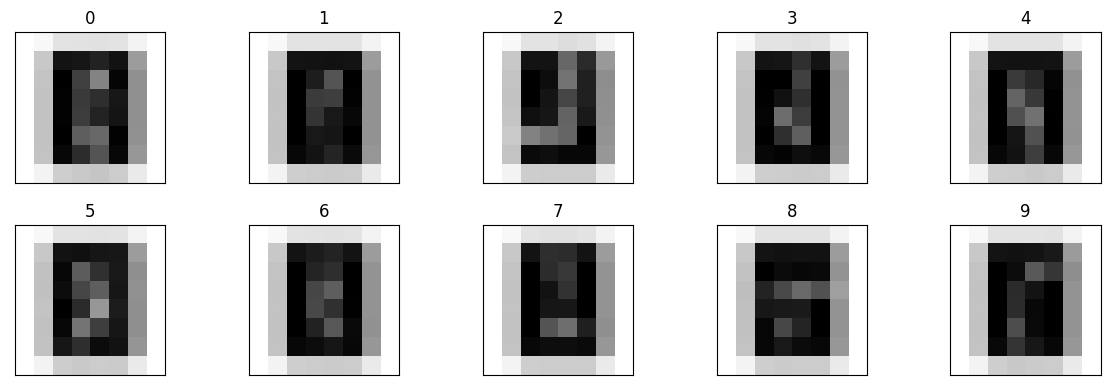

In [11]:
fig, ax = plt.subplots(2, 5, figsize=(12, 4))
for i in range(p4["data"].shape[0]):
    ax[i // 5][i % 5].imshow(p4["data"][i][0].astype(np.uint8), cmap='gray')
    ax[i // 5][i % 5].set_title(str(i))
    ax[i // 5][i % 5].get_xaxis().set_visible(False)
    ax[i // 5][i % 5].get_yaxis().set_visible(False)

fig.tight_layout()

# Custom common functions

In [12]:
class metrics:
    def accuracy(predicted, actual):
        m = actual.size
        correctCount = sum([1 if int(predicted[i]) == int(actual[i]) else 0 for i in range(m)])
        return correctCount / m
    
    def confusionMatrix(predicted, actual, n = 5):
        cnf = np.zeros((n, n), dtype='uint')
        for i in range(actual.size):
            cnf[int(actual[i])][int(predicted[i])] += 1
        return cnf
    
    def f1Score(cnf):
        sum_predict = np.sum(cnf, axis=0)
        sum_actual  = np.sum(cnf, axis=1)
        f1 = np.zeros(cnf.shape[1])
        for i in range(f1.size):
            TP = cnf[i][i]
            FP, FN = sum_predict[i] - TP, sum_actual[i] - TP
            p, r = TP/(TP + FP + 1e-8), TP/(TP + FN + 1e-8)
            f1[i] = 2 * p * r / (p + r + 1e-8)
        return f1      
    
    def print(pred, Y, pred_test, Y_test, result=False):
        n_labels = len(np.unique(Y))
                
        cnf_train = metrics.confusionMatrix(pred, Y, n_labels)
        cnf_test = metrics.confusionMatrix(pred_test, Y_test, n_labels)
        acc_train = metrics.accuracy(pred, Y)
        acc_test = metrics.accuracy(pred_test, Y_test)
        f1_train = metrics.f1Score(cnf_train)
        f1_test = metrics.f1Score(cnf_test)
        
        print("------------------ Train ---------------------")
        print("Classification Accuracy : ", acc_train * 100, "%")
        print("F1 Score                : ", f1_train)
        print("------------------ Test ----------------------")
        print("Classification Accuracy : ", acc_test * 100, "%")
        print("F1 Score                : ", f1_test)
        print("Confusion Matrix        : ")
        print(cnf_test)
        
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax[0].matshow(cnf_train.T, cmap='GnBu')
        ax[0].set_xlabel("Predicted")
        ax[0].set_ylabel("Actual")
        ax[0].set_title("Confusion Matrix (train)")
        for (x, y), value in np.ndenumerate(cnf_train):
            ax[0].text(x, y, f"{value: .0f}", va="center", ha="center")
        
        ax[1].matshow(cnf_test.T, cmap='GnBu')
        ax[1].set_xlabel("Predicted")
        ax[1].set_ylabel("Actual")
        ax[1].set_title("Confusion Matrix (test)")
        for (x, y), value in np.ndenumerate(cnf_test):
            ax[1].text(x, y, f"{value: .0f}", va="center", ha="center")
        
        if result:
            return [acc_train, f1_train], [acc_test, f1_test]

# P1 (SVM)

- For the classification problems given in A1, implement SVMs both with and without slack formulations. 
- Experiment with at least 3 Kernels and grid search on hyper-parameters on different kernels.
- Report your observations (you can use standard python library, LibSVM and need not implement SMO). 
- For multi-class classification, implement a one-vs-rest approach.

**DATA:** `p3train/test.csv`, `images.zip (p4[data])`

In [15]:
# slack: -c 
# grid search on gamma: -g
# kernel: -t 0(linear), 1(polynomial), 2(radial basis)
def svmClassify(X, Y, X_test, Y_test, C, gamma, kernel):
    W = svm_train(Y, X, f"-c {C} -g {gamma} -t {kernel}")
    p_label, p_acc, p_val = svm_predict(Y_test, X_test, W)
    return p_acc[0]

def svmGridSearch(X, Y, X_test, Y_test, C, gamma, kernel):
    best_acc = 0
    best_C = 0
    best_gamma = 0
    for c in C:
        for g in gamma:
            acc = svmClassify(X, Y, X_test, Y_test, c, g, kernel)
            if acc > best_acc:
                best_acc = acc
                best_C = c
                best_gamma = g
    return best_acc, best_C, best_gamma

In [16]:
# Hyperparameters
C = [0, 100]   # 0 -> without slack, 100 -> with slack
G = [0.1, 0.5, 1]
kernels = [0, 1, 2]

## P3 Data

### Linear Kernel

In [ ]:
acc, c, g = svmGridSearch(p3['X'], p3['Y'], p3['X_test'], p3['Y_test'], C, G, kernel[0])
print("       Accuracy : ", acc)
print("Tuned parameters: C = ", c, ", gamma = ", g) 

### Polynomial Kernel

In [ ]:
acc, c, g = svmGridSearch(p3['X'], p3['Y'], p3['X_test'], p3['Y_test'], C, G, kernel[1])
print("       Accuracy : ", acc)
print("Tuned parameters: C = ", c, ", gamma = ", g) 

### Radial basis Kernel

In [ ]:
acc, c, g = svmGridSearch(p3['X'], p3['Y'], p3['X_test'], p3['Y_test'], C, G, kernel[2])
print("       Accuracy : ", acc)
print("Tuned parameters: C = ", c, ", gamma = ", g) 

## P4 Data

### Linear Kernel

In [ ]:
acc, c, g = svmGridSearch(p4['X'], p4['Y'], p4['X_test'], p4['Y_test'], C, G, kernel[0])
print("       Accuracy : ", acc)
print("Tuned parameters: C = ", c, ", gamma = ", g) 

### Polynomial Kernel

In [ ]:
acc, c, g = svmGridSearch(p4['X'], p4['Y'], p4['X_test'], p4['Y_test'], C, G, kernel[1])
print("       Accuracy : ", acc)
print("Tuned parameters: C = ", c, ", gamma = ", g) 

### Radial basis Kernel

In [ ]:
acc, c, g = svmGridSearch(p4['X'], p4['Y'], p4['X_test'], p4['Y_test'], C, G, kernel[2])
print("       Accuracy : ", acc)
print("Tuned parameters: C = ", c, ", gamma = ", g) 

## P5 Data

### Linear Kernel

In [ ]:
acc, c, g = svmGridSearch(p5['X'], p5['Y'], p5['X_test'], p5['Y_test'], C, G, kernel[0])
print("       Accuracy : ", acc)
print("Tuned parameters: C = ", c, ", gamma = ", g) 

### Polynomial Kernel

In [ ]:
acc, c, g = svmGridSearch(p5['X'], p5['Y'], p5['X_test'], p5['Y_test'], C, G, kernel[1])
print("       Accuracy : ", acc)
print("Tuned parameters: C = ", c, ", gamma = ", g) 

### Radial basis Kernel

In [ ]:
acc, c, g = svmGridSearch(p5['X'], p5['Y'], p5['X_test'], p5['Y_test'], C, G, kernel[2])
print("       Accuracy : ", acc)
print("Tuned parameters: C = ", c, ", gamma = ", g) 

# P2 (FLDA)

Implement FLDA for the classification problems in A1 and report the metrics as in A1

**DATA**: `p3train/test.csv`, `images.zip (p4[data])`, `p5[data]`

In [137]:
class FLDA:
    def __init__(self):
        self.num_classes = None
        self.parameters = None
        self.first_label = 0
        self.dimension = 0

    def compute_Sb_Sw(self,X,y):
        self.means = []
        Sb = np.zeros((self.dimension,self.dimension))
        Sw = np.zeros((self.dimension,self.dimension))
        mean = np.mean(X,axis = 0)
        unique , class_count = np.unique(y,return_counts = True)  
        for i in range(self.num_classes):
            self.means.append(np.mean(X[y == i + self.first_label],axis = 0))
            Sb += class_count[i] * (np.array([self.means[i]-mean]).T@np.array([self.means[i]-mean]))
        for j in range(len(X)):
            x = np.array([X[j]])
            m = np.array([self.means[(y[j]-self.first_label).astype(int)]])
            Sw += (x-m).T@(x-m)
        return Sb,Sw 

    def compute_w(self,X,y):
        Sb , Sw = self.compute_Sb_Sw(X,y)
        e_val , e_vec =  np.linalg.eig(np.linalg.pinv(Sw)@Sb)
        idxs = np.argsort(e_val)[::-1][:self.num_classes-1]
        self.parameters = e_vec[:,idxs].T

    def project(self,X):
        return X @ self.parameters.T

    def fit(self, x, y):
        unique = np.unique(y,return_counts = False)
        self.first_label = np.min(y)
        self.num_classes = len(unique)
        self.dimension = x.shape[1]
        self.compute_w(x, y)

    def predict(self,test_data):
        projected_means = np.array(self.means)@self.parameters.T
        projected_data = test_data @ self.parameters.T
        pred_label = np.zeros(len(test_data))
        for i in range(len(test_data)):
            dist = np.sum((projected_means - projected_data[i])**2 , axis = 1)
            pred_label[i] = np.argmin(dist) + self.first_label

        return pred_label

------------------ Train ---------------------
Classification Accuracy :  57.263333333333335 %
F1 Score                :  [0.52778935 0.56287425 0.62782332 0.5873161  0.55754795]
------------------ Test ----------------------
Classification Accuracy :  57.41333333333334 %
F1 Score                :  [0.51742308 0.56262359 0.62537562 0.58599156 0.57841538]
Confusion Matrix        : 
[[1522  395  294  364  396]
 [ 379 1707  284  270  341]
 [ 308  311 1873  252  296]
 [ 346  349  250 1736  294]
 [ 357  325  249  328 1774]]


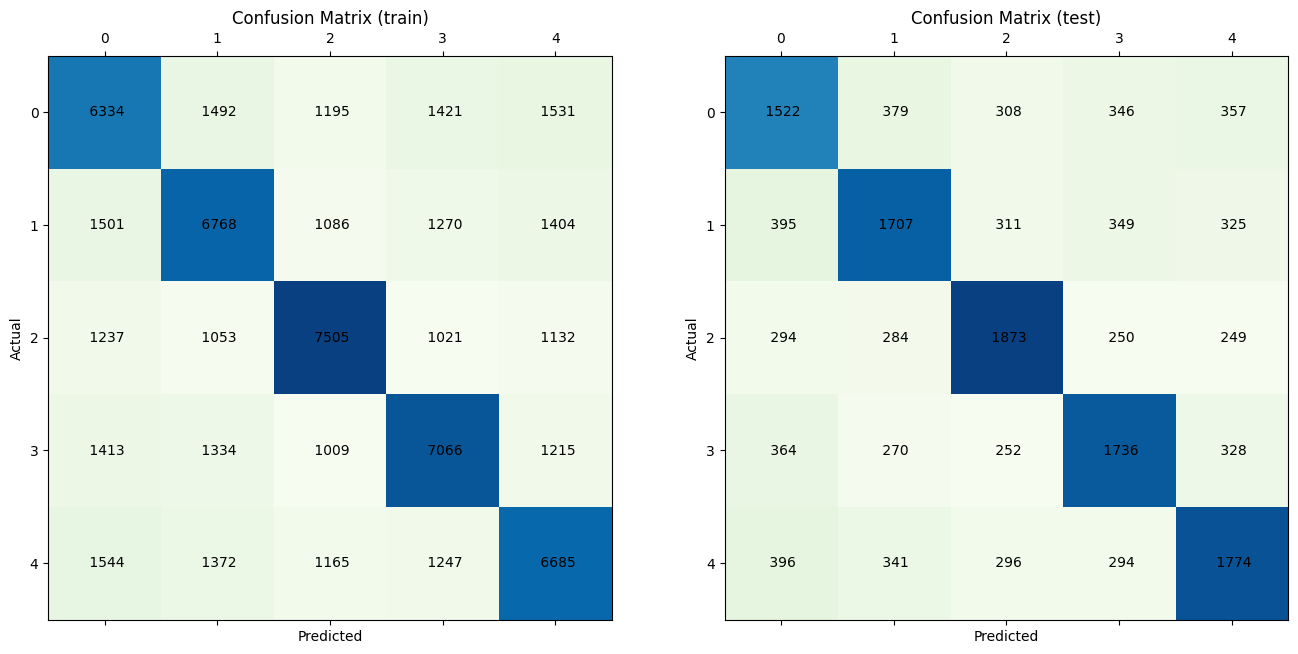

In [200]:
p3_model = FLDA()
p3_model.fit(p3["X"], p3["Y"])
pred = p3_model.predict(p3["X"])
pred_test = p3_model.predict(p3["X_test"])

metrics.print(pred, p3["Y"], pred_test, p3["Y_test"])

------------------ Train ---------------------
Classification Accuracy :  88.40476190476191 %
F1 Score                :  [0.90378869 0.89365628 0.9668858  0.84427429 0.8408551  0.89815043
 0.85488061 0.79873602 0.91883116 0.92919163]
------------------ Test ----------------------
Classification Accuracy :  88.38333333333334 %
F1 Score                :  [0.89511653 0.88997026 0.96818181 0.84026143 0.85205897 0.8973098
 0.85567304 0.79670173 0.92254134 0.92853058]
Confusion Matrix        : 
[[1613  133    2   25   10    0    4    4    8    1]
 [  60 1646    2   56   33    1    0    0    0    2]
 [  24   19 1704   37    2   13    1    0    0    0]
 [  18   26    0 1607   67   23    1   58    0    0]
 [   1    7    0   46 1676   62    0    0    7    1]
 [   1   11   12   46  172 1551    0    1    6    0]
 [   4    5    0   42   27    2 1497  223    0    0]
 [  29    9    0  138   33    1  189 1401    0    0]
 [  24   10    0    4   96    4    0    2 1590   70]
 [  30   33    0   24   18   

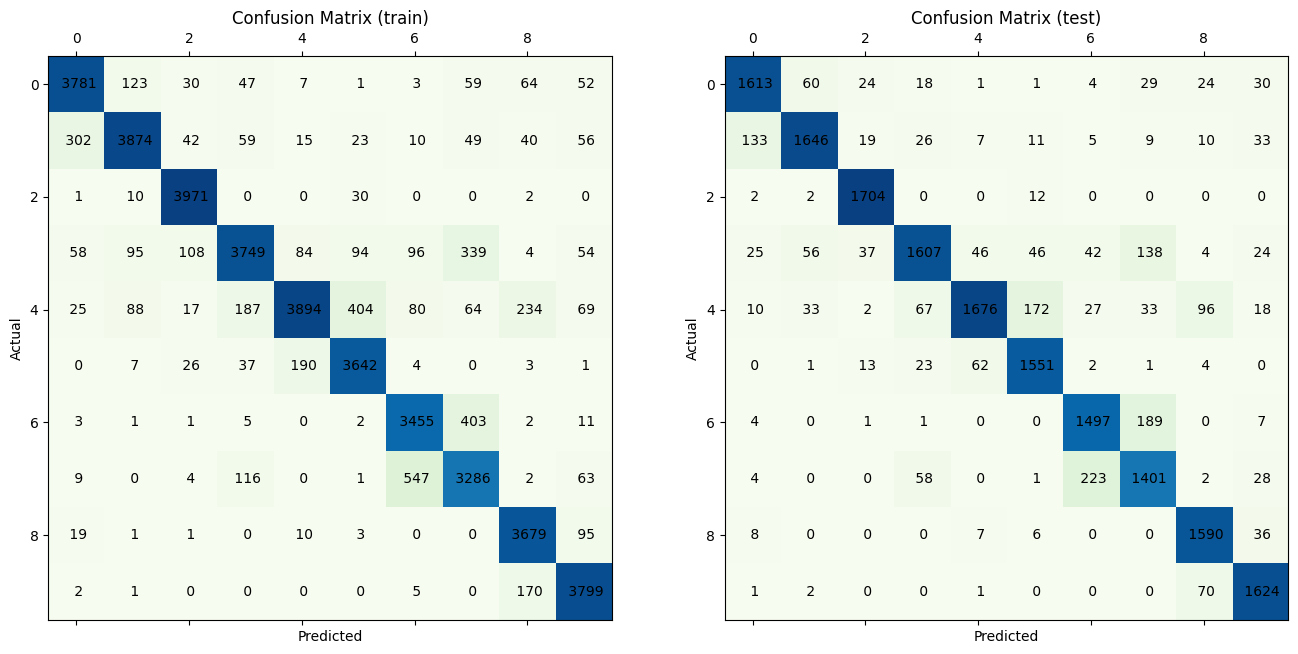

In [270]:
p4_model = FLDA()
p4_model.fit(p4["X"], p4["Y"])
pred = p4_model.predict(p4["X"])
pred_test = p4_model.predict(p4["X_test"])

metrics.print(pred, p4["Y"], pred_test, p4["Y_test"])

------------------ Train ---------------------
Classification Accuracy :  83.59666666666666 %
F1 Score                :  [0.84916966 0.90407358 0.9171587  0.77918215 0.88075965 0.88698234
 0.74750499 0.63678837 0.87582379 0.8871391 ]
------------------ Test ----------------------
Classification Accuracy :  86.26 %
F1 Score                :  [0.88073707 0.90509259 0.91562388 0.85895806 0.92036827 0.88016398
 0.77255985 0.65298776 0.93031123 0.90570021]
Confusion Matrix        : 
[[2581  270    0   49    4    0    3   33   47   13]
 [  63 2737    0  147   10    6    1    3    7   26]
 [  27    9 2561   19    4  366    0    4    9    1]
 [  15    1    4 2704   22   48   20  185    1    0]
 [   0    1    0   47 2849   85    0    3    1   14]
 [   0    7   25   74   84 2791    5    9    4    1]
 [   1    0    0   26    4   12 2517  438    0    2]
 [   1    0    3  187   19   11  965 1814    0    0]
 [ 123   17    1    3   25   17    2    9 2750   53]
 [  50    6    0   40  170    6    3   5

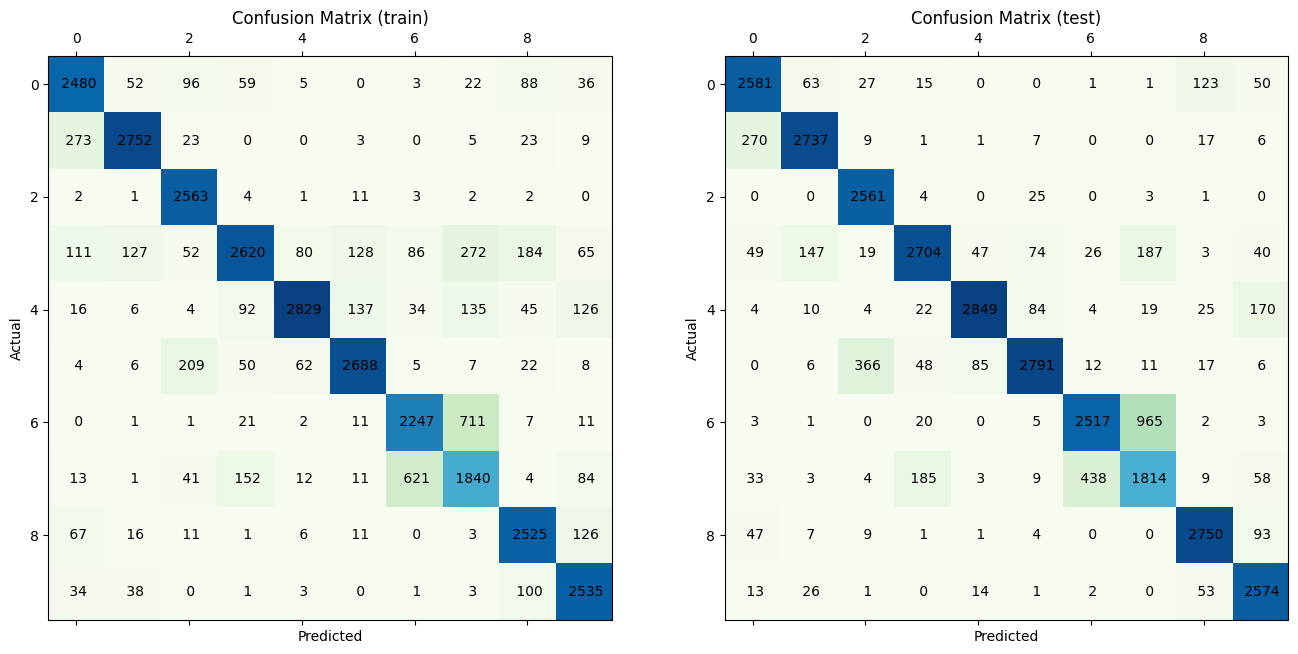

In [202]:
p5_model = FLDA()
p5_model.fit(p5["X"], p5["Y"])
pred = p5_model.predict(p5["X"])
pred_test = p5_model.predict(p5["X_test"])

metrics.print(pred, p5["Y"], pred_test, p5["Y_test"])

# P3 (Regression)

For the regression problem p1 in A1, overfit the data with over-parameterized models (at least 3). 
In the next part, impose different types of regularizers (L2, L1, and a combination of both) and 
plot the bias-variance curves.

**DATA**: `p1train/test.csv`

In [489]:
# Compute mean squared error
def mse(X, Y, W):
    return (1/len(Y)) * (X @ W - Y) @ (X @ W - Y)

def regression(x_train, y_train, x_test, y_test, func = lambda x : x, l1 = 0, l2 = 0, epochs = 100, alpha = 0.0001):
    x_train = func(x_train)
    x_test = func(x_test)
    
    m, n = x_train.shape
    
    optionalString = ""
    
    if l1 == 0 and l2 == 0:
        w = np.linalg.pinv(x_train) @ y_train
    elif l1 == 0 and l2 != 0:
        w = np.linalg.pinv((x_train.T @ x_train) + l2 * np.eye(n, n)) @ x_train.T @ y_train
        optionalString = f" \tl2: {l2}"
    else:
        w = np.linalg.pinv((x_train.T @ x_train) + l2 * np.eye(n, n)) @ (x_train.T @ y_train)
        w = np.linalg.pinv((x_train.T @ x_train) + l2 * np.eye(n, n)) @ (x_train.T @ y_train - l1 * np.sign(w))
        # w = np.linalg.pinv(x_train) @ y_train
        # for i in range(epochs):
        #     w -= alpha * (2 * x_train.T @ (x_train @ w - y_train) + l2 * w + l1 * np.sign(w)) / m
        optionalString = f" \tl1: {l1}" + (f" \tl2: {l2}" if l2 != 0 else "")

    mse_train = mse(x_train, y_train, w)
    mse_test = mse(x_test, y_test, w)
        
    print("MSE (train): ", mse_train, optionalString)
    print("MSE        : ", mse_test, optionalString)
    return [mse_train, mse_test]

def regularizedRegression(X, Y, X_test, Y_test, func = lambda x : x, l1 = 0.01, l2 = 0.01):
    r1 = regression(X, Y, X_test, Y_test, func)
    r2 = regression(X, Y, X_test, Y_test, func, l1=l1)
    r3 = regression(X, Y, X_test, Y_test, func, l2=l2)
    r4 = regression(X, Y, X_test, Y_test, func, l1=l1, l2=l2)
    return [r1, r2, r3, r4]


In [490]:
X, Y = np.c_[np.ones(p1["train"].shape[0]), p1["train"][:, :-1]], p1["train"][:, -1]
X_test, Y_test = np.c_[np.ones(p1["test"].shape[0]), p1["test"][:, :-1]], p1["test"][:, -1]

# Uniform distribution
p3["result"] = [[] for _ in range(9)]
p3["result"][0] = regression(X, Y, X_test, Y_test, lambda x : np.ones(x.shape[0]).reshape(x.shape[0], 1))

MSE (train):  668.234786180195 
MSE        :  688.6933406199939 


## Linear regression

In [491]:
p3["result"][1] = regularizedRegression(X, Y, X_test, Y_test)

MSE (train):  5.059684615643717 
MSE        :  5.0464360039512535 
MSE (train):  5.059684615644732  	l1: 0.01
MSE        :  5.04643612839802  	l1: 0.01
MSE (train):  5.059684615652626  	l2: 0.01
MSE        :  5.046436361668947  	l2: 0.01
MSE (train):  5.0596846156596404  	l1: 0.01 	l2: 0.01
MSE        :  5.046436486121586  	l1: 0.01 	l2: 0.01


## Quadratic regression

In [492]:
def makeQuadratic(data):
    n = data.shape[1]
    return np.array([data.T[i] * data.T[j] for i in range(n) for j in range(n) if j <= i]).T

p3["result"][2] = regularizedRegression(X, Y, X_test, Y_test, makeQuadratic)

MSE (train):  5.057337646427746 
MSE        :  5.0460393419222935 
MSE (train):  5.057337646431241  	l1: 0.01
MSE        :  5.04603936140009  	l1: 0.01
MSE (train):  5.0573376464595325  	l2: 0.01
MSE        :  5.04603939128649  	l2: 0.01
MSE (train):  5.0573376464841  	l1: 0.01 	l2: 0.01
MSE        :  5.046039410784836  	l1: 0.01 	l2: 0.01


## Cubic regression

In [493]:
def makeCubic(data):
    n = data.shape[1]
    return np.array([data.T[i] * data.T[j] * data.T[k] for i in range(n) for j in range(n) for k in range(n) if j <= i and k <= j]).T

p3["result"][3] = regularizedRegression(X, Y, X_test, Y_test, makeCubic)

MSE (train):  5.055143947861669 
MSE        :  5.0504576371743 
MSE (train):  5.055143947865257  	l1: 0.01
MSE        :  5.05045765867438  	l1: 0.01
MSE (train):  5.055143947893704  	l2: 0.01
MSE        :  5.050457688063318  	l2: 0.01
MSE (train):  5.055143947918639  	l1: 0.01 	l2: 0.01
MSE        :  5.050457709582472  	l1: 0.01 	l2: 0.01


## Non-Linear regression (degree: 4)
$h_3(x) = h_1(h_1(x))$

In [494]:
p3["result"][4] = regularizedRegression(X, Y, X_test, Y_test, lambda x : makeQuadratic(makeQuadratic(x)))

MSE (train):  5.052063535022622 
MSE        :  5.053306488271599 
MSE (train):  5.05206353503174  	l1: 0.01
MSE        :  5.053306686726845  	l1: 0.01
MSE (train):  5.0520635350949945  	l2: 0.01
MSE        :  5.05330703002223  	l2: 0.01
MSE (train):  5.052063535148826  	l1: 0.01 	l2: 0.01
MSE        :  5.053307209308933  	l1: 0.01 	l2: 0.01


## Non-Linear regression (degree: 5)
$h_4(x) = h_1(h_2(x))$

In [495]:
p3["result"][5] = regularizedRegression(X, Y, X_test, Y_test, lambda x : makeQuadratic(makeCubic(x)))

MSE (train):  5.036182828226298 
MSE        :  5.059898421648326 
MSE (train):  5.77459501671974  	l1: 0.01
MSE        :  5.784863537578888  	l1: 0.01
MSE (train):  5.772633259254229  	l2: 0.01
MSE        :  5.782935498270248  	l2: 0.01
MSE (train):  5.772633302409802  	l1: 0.01 	l2: 0.01
MSE        :  5.78293551111653  	l1: 0.01 	l2: 0.01


## Non-Linear regression (degree: 6)
$h_5(x) = h_2(h_2(x))$

In [496]:
p3["result"][6] = regularizedRegression(X, Y, X_test, Y_test, lambda x : makeCubic(makeCubic(x)))

MSE (train):  5.025080763598227 
MSE        :  5.074239570702316 
MSE (train):  35.41145340757321  	l1: 0.01
MSE        :  35.6028826675592  	l1: 0.01
MSE (train):  35.41436416641033  	l2: 0.01
MSE        :  35.60654040708519  	l2: 0.01
MSE (train):  35.41436417052992  	l1: 0.01 	l2: 0.01
MSE        :  35.60653613533971  	l1: 0.01 	l2: 0.01


## Non-Linear regression (degree: 7)
$h_6(x) = h_1(h_1(h_2(x)))$

In [487]:
p3["result"][7] = regularizedRegression(X, Y, X_test, Y_test, lambda x : makeQuadratic(makeQuadratic(makeCubic(x))))

MSE (train):  7.278581524675927 
MSE        :  7.492180313509383 
MSE (train):  160.64729551389888  	l1: 1
MSE        :  167.2991392729456  	l1: 1
MSE (train):  160.64729551389777  	l2: 1
MSE        :  167.2991405022811  	l2: 1
MSE (train):  160.6472955138958  	l1: 1 	l2: 1
MSE        :  167.29913921437486  	l1: 1 	l2: 1


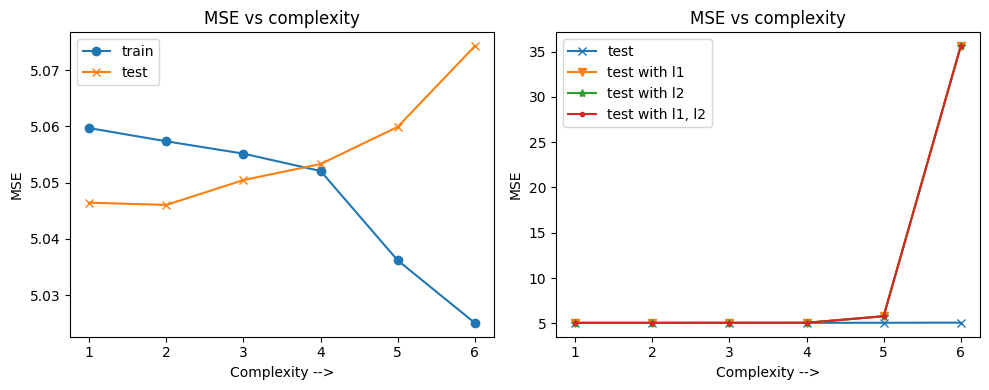

In [497]:
count = 6
results = np.array(p3["result"][1:count+1])
fig, [ax, ax1] = plt.subplots(1, 2, figsize=(10, 4))
ax.plot([i + 1 for i in range(count)], results[:, 0, 0], label="train", marker='o')
ax.plot([i + 1 for i in range(count)], results[:, 0, 1], label="test", marker='x')
ax.set_xlabel("Complexity -->")
ax.set_ylabel("MSE")
ax.legend()
ax.set_title("MSE vs complexity")

# ax1.plot([i + 1 for i in range(count)], results[:, 0, 0], label="train", marker='o')
ax1.plot([i + 1 for i in range(count)], results[:, 0, 1], label="test", marker='x')
ax1.plot([i + 1 for i in range(count)], results[:, 1, 1], label="test with l1", marker='v')
ax1.plot([i + 1 for i in range(count)], results[:, 2, 1], label="test with l2", marker='*')
ax1.plot([i + 1 for i in range(count)], results[:, 3, 1], label="test with l1, l2", marker='.')
ax1.set_xlabel("Complexity -->")
ax1.set_ylabel("MSE")
ax1.legend()
ax1.set_title("MSE vs complexity")

fig.tight_layout()

# Custom functions for Neural Networks

## 1. Multi-Layer Perceptron

In [ ]:
class MLP:
    def __init__(self, sizes, activation='sigmoid', activation_last_layer='softmax', loss='ce', learning_rate=0.01, random_seed=42):
        np.random.seed(random_seed)
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.activation = activation
        self.activation_last_layer = activation_last_layer
        self.loss = loss
        self.learning_rate = learning_rate
        self.weights = [np.random.randn(sizes[i], sizes[i-1]) / np.sqrt(sizes[i-1]) for i in range(1, self.num_layers)]
        self.biases = [np.random.randn(sizes[i], 1) for i in range(1, self.num_layers)]

    def sigmoid(self, z):
        return 1.0 / (1.0 + np.exp(-z))

    def sigmoid_prime(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def relu(self, z):
        return np.maximum(0, z)

    def relu_prime(self, z):
        return np.where(z > 0, 1, 0)


    def softmax(self, z):
        exp_z = np.exp(z - np.max(z))
        return exp_z / np.sum(exp_z, axis=0, keepdims=True)

    def softmax_prime(self, z):
        return self.softmax(z) * (1 - self.softmax(z))

    def cross_entropy_loss(self, y, y_pred):
        m = y.shape[1]
        cost = -1/m * np.sum(y * np.log(y_pred + 1e-8))
        return np.squeeze(cost)

    def cross_entropy_loss_prime(self, y, y_pred):
        return y_pred - y

    def squared_error_loss(self, y, y_pred):
        m = y.shape[1]
        cost = 1/(2*m) * np.sum((y_pred - y)**2)
        return np.squeeze(cost)

    def squared_error_loss_prime(self, y, y_pred):
        return y_pred - y

    def forward(self, X):
        a = X.T
        for i in range(self.num_layers-1):
            z = np.dot(self.weights[i], a) + self.biases[i]
            if i == self.num_layers-2:
                if self.activation_last_layer == 'softmax':
                    a = self.softmax(z)
            else:
                if self.activation == 'sigmoid':
                    a = self.sigmoid(z)
                elif self.activation == 'relu':
                    a = self.relu(z)
                    
        return a.T


    def backward(self, X, y):
        m = X.shape[0]
        a = [X.T]
        z_s = []
        for i in range(self.num_layers-1):
            z = np.dot(self.weights[i], a[-1]) + self.biases[i]
            z_s.append(z)
            if i == self.num_layers-2:
                if self.activation_last_layer == 'softmax':
                    a.append(self.softmax(z))
            else:
                if self.activation == 'sigmoid':
                    a.append(self.sigmoid(z))
                elif self.activation == 'relu':
                    a.append(self.relu(z))
                    
        if self.loss == 'ce':
            d_a = self.cross_entropy_loss_prime(y.T, a[-1])
        elif self.loss == 'mse':
            d_a = self.squared_error_loss_prime(y.T, a[-1])
            
        d_z = d_a
        d_weights = []
        d_biases = []
        for i in range(self.num_layers-2, -1, -1):
            d_weights.insert(0, np.dot(d_z, a[i].T) / m)
            d_biases.insert(0, np.sum(d_z, axis=1, keepdims=True) / m)
            if i > 0:
                if self.activation == 'sigmoid':
                    d_z = np.dot(self.weights[i].T, d_z) * self.sigmoid_prime(z_s[i-1])
                elif self.activation == 'relu':
                    d_z = np.dot(self.weights[i].T, d_z) * self.relu_prime(z_s[i-1])
                    
        return d_weights, d_biases
    

    def train(self, X_train, Y_train, X_val, Y_val, num_epochs, batch_size): 
        n_labels = len(np.unique(Y_train))
        y_train, y_val = [np.zeros((y.shape[0], n_labels)) for y in [Y_train, Y_val]]
        for i, j in enumerate(Y_train):
            y_train[i][int(j)] = 1
        for i, j in enumerate(Y_val):
            y_val[i][int(j)] = 1   
            
        train_losses = []
        val_losses = []
        train_accs = []
        val_accs = []
        
        for i in range(num_epochs):
            permutation = np.random.permutation(X_train.shape[0])
            X_train = X_train[permutation, :]
            y_train = y_train[permutation]
            
            for j in range(0, X_train.shape[0], batch_size):
                
                X_batch = X_train[j : j + batch_size, :]
                y_batch = y_train[j : j + batch_size]
                
                d_weights, d_biases = self.backward(X_batch, y_batch)
                
                for k in range(len(self.weights)):
                    self.weights[k] -= self.learning_rate * d_weights[k]
                    self.biases[k] -= self.learning_rate * d_biases[k]
                    
            y_pred_train = self.forward(X_train)
            y_pred_val = self.forward(X_val)
            
            if self.loss == 'ce':
                train_loss = self.cross_entropy_loss(y_train, y_pred_train)
                val_loss = self.cross_entropy_loss(y_val, y_pred_val)
            elif self.loss == 'mse':
                train_loss = self.squared_error_loss(y_train, y_pred_train)
                val_loss = self.squared_error_loss(y_val, y_pred_val)
                
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            acc_params_train = [np.argmax(y_train, axis=1), np.argmax(y_pred_train, axis=1)]
            acc_params_val = [np.argmax(y_val, axis=1), np.argmax(y_pred_val, axis=1)]
            
            train_acc = metrics.accuracy(*acc_params_train)
            val_acc = metrics.accuracy(*acc_params_val)
            
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            
            # train_f1 = metrics.f1Score(metrics.confusionMatrix(*acc_params_train, n_labels))
            # val_f1 = metrics.f1Score(metrics.confusionMatrix(*acc_params_val, n_labels))
            
            print(f"Epoch {i+1}: \t  train_loss = {train_loss:.2f}  \tval_loss = {val_loss:.2f} \t  train_acc = {train_acc:.2f}  \t val_acc = {val_acc:.2f}")
        return train_losses, val_losses, train_accs, val_accs

## 2. CNN

In [500]:
class Conv3x3:
  def __init__(self, num_filters):
    self.num_filters = num_filters
    self.filters = np.random.randn(num_filters, 3, 3) / 9

  def iterate_regions(self, image):
    h, w = image.shape
    for i in range(h - 2):
      for j in range(w - 2):
        im_region = image[i:(i + 3), j:(j + 3)]
        yield im_region, i, j

  def forward(self, input):
    self.last_input = input
    h, w = input.shape

    output = np.zeros((h - 2, w - 2, self.num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.sum(im_region * self.filters, axis=(1, 2))

    return output

  def backprop(self, d_L_d_out, learn_rate):
    d_L_d_filters = np.zeros(self.filters.shape)
    for im_region, i, j in self.iterate_regions(self.last_input):
      for f in range(self.num_filters):
        d_L_d_filters[f] += d_L_d_out[i, j, f] * im_region

    self.filters -= learn_rate * d_L_d_filters
    pass

In [501]:
class MaxPool2:
  def iterate_regions(self, image):
    h, w, _ = image.shape
    new_h = h // 2
    new_w = w // 2

    for i in range(new_h):
      for j in range(new_w):
        im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
        yield im_region, i, j

  def forward(self, input):
    self.last_input = input

    h, w, num_filters = input.shape
    output = np.zeros((h // 2, w // 2, num_filters))

    for im_region, i, j in self.iterate_regions(input):
      output[i, j] = np.amax(im_region, axis=(0, 1))

    return output

  def backprop(self, d_L_d_out):
    d_L_d_input = np.zeros(self.last_input.shape)

    for im_region, i, j in self.iterate_regions(self.last_input):
      h, w, f = im_region.shape
      amax = np.amax(im_region, axis=(0, 1))

      for i2 in range(h):
        for j2 in range(w):
          for f2 in range(f):
            if im_region[i2, j2, f2] == amax[f2]:
              d_L_d_input[i * 2 + i2, j * 2 + j2, f2] = d_L_d_out[i, j, f2]

    return d_L_d_input

In [502]:
class AvgPool2:
    def iterate_regions(self, image):
        h, w, _ = image.shape
        new_h = h // 2
        new_w = w // 2

        for i in range(new_h):
            for j in range(new_w):
                im_region = image[(i * 2):(i * 2 + 2), (j * 2):(j * 2 + 2)]
                yield im_region, i, j

    def forward(self, input):
        self.last_input = input

        h, w, num_filters = input.shape
        output = np.zeros((h // 2, w // 2, num_filters))

        for im_region, i, j in self.iterate_regions(input):
            output[i, j] = np.mean(im_region, axis=(0, 1))

        return output

    def backprop(self, d_L_d_out):
        d_L_d_input = np.zeros(self.last_input.shape)

        for im_region, i, j in self.iterate_regions(self.last_input):
            h, w, f = im_region.shape
            avg = np.mean(im_region, axis=(0, 1))

            for i2 in range(h):
                for j2 in range(w):
                    for f2 in range(f):
                        d_L_d_input[i * 2 + i2, j * 2 + j2, f2] += d_L_d_out[i, j, f2] / (2*2)

        return d_L_d_input

In [503]:
class Softmax:
  def __init__(self, input_len, nodes):
    self.weights = np.random.randn(input_len, nodes) / input_len
    self.biases = np.zeros(nodes)

  def forward(self, input):
    self.last_input_shape = input.shape
    input = input.flatten()
    self.last_input = input

    input_len, nodes = self.weights.shape
    totals = np.dot(input, self.weights) + self.biases
    self.last_totals = totals
    exp = np.exp(totals)
    return exp / np.sum(exp, axis=0)

  def backprop(self, d_L_d_out, learn_rate):
    for i, gradient in enumerate(d_L_d_out):
      if gradient == 0:
        continue

      t_exp = np.exp(self.last_totals)
      S = np.sum(t_exp)

      d_out_d_t = -t_exp[i] * t_exp / (S ** 2)
      d_out_d_t[i] = t_exp[i] * (S - t_exp[i]) / (S ** 2)

      d_t_d_w = self.last_input
      d_t_d_b = 1
      d_t_d_inputs = self.weights

      d_L_d_t = gradient * d_out_d_t

      d_L_d_w = d_t_d_w[np.newaxis].T @ d_L_d_t[np.newaxis]
      d_L_d_b = d_L_d_t * d_t_d_b
      d_L_d_inputs = d_t_d_inputs @ d_L_d_t

      self.weights -= learn_rate * d_L_d_w
      self.biases -= learn_rate * d_L_d_b

      return d_L_d_inputs.reshape(self.last_input_shape)

In [510]:
class layer_activation:    
    def __init__(self,activation='sigmoid'):
        self.act = activation
        return
    
    def relu(self,x):
        return x * (x > 0)

    def grad_relu(self,x):
        return 1. * (x > 0)

    def tanh(self,x):
        return (2.0/(1.0 + np.exp(-2.0*x))) - 1

    def grad_tanh(self,x):
        y = self.tanh(x)
        return (1.0-(y**2))

    def sigmoid(self,x):
        return 1.0/(1.0 + np.exp(-1.0*x))

    def grad_sigmoid(self,x):
        y = self.sigmoid(x)
        return y*(1.0-y)

    act_dispatcher = {'sigmoid' : sigmoid, 'tanh': tanh, 'relu' : relu}
    act_grad_dispatcher = {'sigmoid' : grad_sigmoid, 'tanh': grad_tanh, 'relu' : grad_relu}
    
    def call_activation(self, x, func):
        try:
            return self.act_dispatcher[func](self, x)
        except:
            return "Invalid activation function"

    def call_grad_activation(self, x, func):
        try:
            return self.act_grad_dispatcher[func](self, x)
        except:
            return "Invalid grad activation function"
    
    def forward_pass(self,X):
        self.x_in = X
        self.out = self.call_activation(X, self.act)

        return self.out
    
    def backward_pass(self,delta):        
        delta_prev = np.multiply(delta,self.call_grad_activation(self.x_in, self.act))
                
        return delta_prev
    
    def output_shape(self, x):        
        return x

# P4 (Neural Networks, MLP)

- Construct a Multi-layer Perception (MLP) or a feed-forward neural network to work on the K-MNIST dataset. 
- Experiment with at least 3 settings of the number of hidden layers and Neurons. 
- Explicitly code the Error Backpropagation algorithm as a class and use it on MLPs with different architectures and loss functions (CE, squared error loss).
- For this part, you should only use Numpy. 

Report the accuracy and F1 scores with all the considered configurations.

**DATA:** `images.zip (p4['data'])`

In [276]:
mlp = [[] for _ in range(4)]
n_labels = len(np.unique(p4['Y']))

# Shuffle the training data randomly
indices = np.arange(p4['X'].shape[0])
np.random.shuffle(indices)

s = int(0.7 * p4['X'].shape[0])
xtrain, xval = p4['X'][indices[:s]], p4['X'][indices[s:]]
ytrain, yval = p4['Y'][indices[:s]], p4['Y'][indices[s:]]

layers = [xtrain.shape[1], 128, 64, 32, n_labels]
mlp[0] = MLP(layers, 'sigmoid', 'softmax','ce', learning_rate = 0.1)

train_losses, val_losses, train_accs, val_accs = mlp[0].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

Epoch 1: 	  train_loss = 6772.50  	val_loss = 2904.61 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 2: 	  train_loss = 6772.33  	val_loss = 2904.17 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 3: 	  train_loss = 6771.86  	val_loss = 2904.27 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 4: 	  train_loss = 6772.97  	val_loss = 2904.68 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 5: 	  train_loss = 6771.38  	val_loss = 2903.73 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 6: 	  train_loss = 6772.12  	val_loss = 2902.43 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 7: 	  train_loss = 6772.88  	val_loss = 2904.64 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 8: 	  train_loss = 6772.63  	val_loss = 2904.06 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 9: 	  train_loss = 6774.03  	val_loss = 2903.83 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 10: 	  train_loss = 6770.47  	val_loss = 2902.42 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 11: 	  train_loss = 6770.81  	val_loss = 2903.38 	  train_acc = 0.10  	 v

In [277]:
layers = [xtrain.shape[1], 256, 128, 64, 32, n_labels]
mlp[1] = MLP(layers, 'relu', 'softmax','ce', learning_rate = 0.01)

train_losses, val_losses, train_accs, val_accs = mlp[1].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

Epoch 1: 	  train_loss = 6724.05  	val_loss = 2882.97 	  train_acc = 0.14  	 val_acc = 0.13
Epoch 2: 	  train_loss = 6691.24  	val_loss = 2868.91 	  train_acc = 0.24  	 val_acc = 0.24
Epoch 3: 	  train_loss = 6662.83  	val_loss = 2856.92 	  train_acc = 0.22  	 val_acc = 0.22
Epoch 4: 	  train_loss = 6618.63  	val_loss = 2837.89 	  train_acc = 0.20  	 val_acc = 0.19
Epoch 5: 	  train_loss = 6555.90  	val_loss = 2809.07 	  train_acc = 0.42  	 val_acc = 0.43
Epoch 6: 	  train_loss = 6469.59  	val_loss = 2773.06 	  train_acc = 0.43  	 val_acc = 0.44
Epoch 7: 	  train_loss = 6342.79  	val_loss = 2718.56 	  train_acc = 0.43  	 val_acc = 0.43
Epoch 8: 	  train_loss = 6170.58  	val_loss = 2641.76 	  train_acc = 0.37  	 val_acc = 0.38
Epoch 9: 	  train_loss = 6015.64  	val_loss = 2583.87 	  train_acc = 0.25  	 val_acc = 0.26
Epoch 10: 	  train_loss = 6260.84  	val_loss = 2697.50 	  train_acc = 0.11  	 val_acc = 0.11
Epoch 11: 	  train_loss = 6514.92  	val_loss = 2778.25 	  train_acc = 0.13  	 v

In [278]:
layers = [xtrain.shape[1], 128, 64, 32, n_labels]
mlp[2] = MLP(layers, 'sigmoid', 'softmax','mse', learning_rate = 0.01)

train_losses, val_losses, train_accs, val_accs = mlp[2].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

Epoch 1: 	  train_loss = 1337.57  	val_loss = 573.80 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 2: 	  train_loss = 1324.50  	val_loss = 567.93 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 3: 	  train_loss = 1323.09  	val_loss = 567.22 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 4: 	  train_loss = 1322.97  	val_loss = 567.15 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 5: 	  train_loss = 1322.96  	val_loss = 567.13 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 6: 	  train_loss = 1322.95  	val_loss = 567.11 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 7: 	  train_loss = 1322.95  	val_loss = 567.12 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 8: 	  train_loss = 1322.96  	val_loss = 567.11 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 9: 	  train_loss = 1322.95  	val_loss = 567.11 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 10: 	  train_loss = 1322.95  	val_loss = 567.11 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 11: 	  train_loss = 1322.95  	val_loss = 567.11 	  train_acc = 0.10  	 val_acc = 0.

In [279]:
layers = [xtrain.shape[1], 128, 64, 32, n_labels]
mlp[3] = MLP(layers, 'relu', 'softmax','mse', learning_rate = 0.1)

train_losses, val_losses, train_accs, val_accs = mlp[3].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

Epoch 1: 	  train_loss = 1312.71  	val_loss = 562.93 	  train_acc = 0.20  	 val_acc = 0.19
Epoch 2: 	  train_loss = 1277.06  	val_loss = 547.29 	  train_acc = 0.23  	 val_acc = 0.22
Epoch 3: 	  train_loss = 1189.88  	val_loss = 511.03 	  train_acc = 0.21  	 val_acc = 0.21
Epoch 4: 	  train_loss = 1200.20  	val_loss = 512.60 	  train_acc = 0.22  	 val_acc = 0.23
Epoch 5: 	  train_loss = 1171.75  	val_loss = 501.69 	  train_acc = 0.26  	 val_acc = 0.26
Epoch 6: 	  train_loss = 1332.70  	val_loss = 570.87 	  train_acc = 0.16  	 val_acc = 0.16
Epoch 7: 	  train_loss = 1235.68  	val_loss = 528.01 	  train_acc = 0.20  	 val_acc = 0.20
Epoch 8: 	  train_loss = 896.68  	val_loss = 385.17 	  train_acc = 0.53  	 val_acc = 0.53
Epoch 9: 	  train_loss = 1268.54  	val_loss = 543.07 	  train_acc = 0.16  	 val_acc = 0.16
Epoch 10: 	  train_loss = 823.57  	val_loss = 351.75 	  train_acc = 0.58  	 val_acc = 0.58
Epoch 11: 	  train_loss = 1075.34  	val_loss = 461.84 	  train_acc = 0.35  	 val_acc = 0.35

#### Final accuracy and F1 score

In [280]:
models = ["3 hidden layers, activation function: 'sigmoid', loss function: 'cross-entropy'",
         "4 hidden layers, activation function: 'relu', loss function: 'mean squared error'",
         "3 hidden layers, activation function: 'sigmoid', loss function: 'cross-entropy'",
         "3 hidden layers, activation function: 'relu', loss function: 'mean squared error'"]

for i in range(4):
    pred = np.argmax(mlp[i].forward(p4['X_test']), axis=1)
    cnf = metrics.confusionMatrix(pred, p4['Y_test'], n_labels)
    acc = metrics.accuracy(pred, p4['Y_test'])
    f1 = metrics.f1Score(cnf)
                         
    print(models[i])
    print("Classification Accuracy : ", acc * 100, "%")
    print("               F1 Score : ", np.mean(f1))
    print("-------------------------------------------------------------------------------------")

3 hidden layers, activation function: 'sigmoid', loss function: 'cross-entropy'
Classification Accuracy :  21.205555555555556 %
               F1 Score :  0.09491137271588837
-------------------------------------------------------------------------------------
4 hidden layers, activation function: 'relu', loss function: 'mean squared error'
Classification Accuracy :  85.62222222222222 %
               F1 Score :  0.8556740540704817
-------------------------------------------------------------------------------------
3 hidden layers, activation function: 'sigmoid', loss function: 'cross-entropy'
Classification Accuracy :  10.0 %
               F1 Score :  0.01819008623753513
-------------------------------------------------------------------------------------
3 hidden layers, activation function: 'relu', loss function: 'mean squared error'
Classification Accuracy :  89.3 %
               F1 Score :  0.893049386450607
----------------------------------------------------------------------

# P5 (Neural Networks, CNN)

- Construct a CNN for the K-MNIST dataset and code the back-propagation algorithm with weight sharing and local-receptive fields. 
- Experiment with 3 different architectures and report the accuracy.

**DATA:** `images.zip (p4[data])`

## Data Handling

In [498]:
p4["full_data"] = genFromImage(imageDir, (28, 28))
p4X, p4Y, p4Xt, p4Yt, _ = trainTestSplit(p4["full_data"], 0.7, imgToFeatures)

train_images, train_labels = p4X.reshape(p4X.shape[0], 28, 28), p4Y.astype('int')
test_images, test_labels = p4Xt.reshape(p4Xt.shape[0], 28, 28), p4Yt.astype('int')

p4X.shape, p4Y.shape, p4Xt.shape, p4Yt.shape, train_images.shape, test_images.shape

((42000, 784),
 (42000,),
 (18000, 784),
 (18000,),
 (42000, 28, 28),
 (18000, 28, 28))

## Architecture 1

In [512]:
conv = Conv3x3(8)
pool = MaxPool2()
softmax = Softmax(13 * 13 * 8 , 10)

def forward(image, label):
  out = conv.forward(image - 0.5)
  out = pool.forward(out)
  out = softmax.forward(out)
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):
  out, loss, acc = forward(im, label)
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

print('Training the CNN Architecture 1 !\n')
for epoch in range(1):
  print('--- Epoch %d ---' % (epoch + 1))
  permutation = np.random.permutation(train_images.shape[0])
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 5000 == 4999 :
      print(
        '[Step %d] Past 5000 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 5000, num_correct / 50)
      )
      loss = 0
      num_correct = 0

    l , acc = train(im, label)

    loss += l
    num_correct += acc

print('\nTesting the CNN Architecture 1 !')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss for Architecture 1 :', loss / num_tests)
print('Test Accuracy for Architecture 1 : ' + str((num_correct / num_tests) * 100) +"%")


Training the CNN Architecture 1 !

--- Epoch 1 ---
[Step 5000] Past 5000 steps: Average Loss 0.826 | Accuracy: 71%
[Step 10000] Past 5000 steps: Average Loss 0.274 | Accuracy: 91%
[Step 15000] Past 5000 steps: Average Loss 0.237 | Accuracy: 92%
[Step 20000] Past 5000 steps: Average Loss 0.196 | Accuracy: 93%
[Step 25000] Past 5000 steps: Average Loss 0.203 | Accuracy: 93%
[Step 30000] Past 5000 steps: Average Loss 0.151 | Accuracy: 95%
[Step 35000] Past 5000 steps: Average Loss 0.170 | Accuracy: 94%
[Step 40000] Past 5000 steps: Average Loss 0.160 | Accuracy: 95%

Testing the CNN Architecture 1 !
Test Loss for Architecture 1 : 0.16404584725259944
Test Accuracy for Architecture 1 : 94.99444444444445%


## Architecture 2

In [513]:
conv = Conv3x3(8)
relu = layer_activation("relu")
pool = MaxPool2()
sigmoid = layer_activation("sigmoid")
softmax = Softmax(13 * 13 * 8 , 10)

def forward(image, label):
  out = conv.forward(image - 0.5)
  out = relu.forward_pass(out)
  out = sigmoid.forward_pass(out)
  out = pool.forward(out)
  out = softmax.forward(out)
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):
  out, loss, acc = forward(im, label)
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = sigmoid.backward_pass(gradient)
  gradient = relu.backward_pass(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

for epoch in range(1):
  print('--- Epoch %d ---' % (epoch + 1))
  permutation = np.random.permutation(train_images.shape[0])
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 5000 == 4999 :
      print(
        '[Step %d] Past 5000 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 5000, num_correct / 50)
      )
      loss = 0
      num_correct = 0

    l , acc = train(im, label)

    loss += l
    num_correct += acc

print('\nTesting the CNN Architecture 2 !')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss for Architecture 2 :', loss / num_tests)
print('Test Accuracy for Architecture 2 : ' + str((num_correct / num_tests) * 100) + "%")

--- Epoch 1 ---
[Step 5000] Past 5000 steps: Average Loss 2.725 | Accuracy: 9%
[Step 10000] Past 5000 steps: Average Loss 2.347 | Accuracy: 17%
[Step 15000] Past 5000 steps: Average Loss 1.169 | Accuracy: 59%
[Step 20000] Past 5000 steps: Average Loss 0.583 | Accuracy: 83%
[Step 25000] Past 5000 steps: Average Loss 0.430 | Accuracy: 87%
[Step 30000] Past 5000 steps: Average Loss 0.349 | Accuracy: 89%
[Step 35000] Past 5000 steps: Average Loss 0.319 | Accuracy: 90%
[Step 40000] Past 5000 steps: Average Loss 0.304 | Accuracy: 91%

Testing the CNN Architecture 2 !
Test Loss for Architecture 2 : 0.3003426599503643
Test Accuracy for Architecture 2 : 91.08888888888889%


## Architecture 3

In [514]:
conv = Conv3x3(8)
relu = layer_activation("relu")
pool = AvgPool2()
softmax = Softmax(13 * 13 * 8, 10)

def forward(image, label):
  out = conv.forward(image - 0.5)
  out = relu.forward_pass(out)
  out = pool.forward(out)
  out = softmax.forward(out)
  loss = -np.log(out[label])
  acc = 1 if np.argmax(out) == label else 0

  return out, loss, acc

def train(im, label, lr=.005):
  out, loss, acc = forward(im, label)
  gradient = np.zeros(10)
  gradient[label] = -1 / out[label]
  gradient = softmax.backprop(gradient, lr)
  gradient = pool.backprop(gradient)
  gradient = relu.backward_pass(gradient)
  gradient = conv.backprop(gradient, lr)

  return loss, acc

for epoch in range(1):
  print('--- Epoch %d ---' % (epoch + 1))
  permutation = np.random.permutation(train_images.shape[0])
  train_images = train_images[permutation]
  train_labels = train_labels[permutation]
  loss = 0
  num_correct = 0
  for i, (im, label) in enumerate(zip(train_images, train_labels)):
    if i % 5000 == 4999 :
      print(
        '[Step %d] Past 5000 steps: Average Loss %.3f | Accuracy: %d%%' %
        (i + 1, loss / 5000, num_correct / 50)
      )
      loss = 0
      num_correct = 0
    l , acc = train(im, label)
    loss += l
    num_correct += acc

print('\nTesting the CNN Architecture 3 !')
loss = 0
num_correct = 0
for im, label in zip(test_images, test_labels):
  _, l, acc = forward(im, label)
  loss += l
  num_correct += acc

num_tests = len(test_images)
print('Test Loss for Architecture 3 :', loss / num_tests)
print('Test Accuracy for Architecture 3 : ' + str((num_correct / num_tests) * 100) + "%")

--- Epoch 1 ---
[Step 5000] Past 5000 steps: Average Loss 0.931 | Accuracy: 69%
[Step 10000] Past 5000 steps: Average Loss 0.323 | Accuracy: 89%
[Step 15000] Past 5000 steps: Average Loss 0.254 | Accuracy: 92%
[Step 20000] Past 5000 steps: Average Loss 0.240 | Accuracy: 92%
[Step 25000] Past 5000 steps: Average Loss 0.211 | Accuracy: 93%
[Step 30000] Past 5000 steps: Average Loss 0.226 | Accuracy: 93%
[Step 35000] Past 5000 steps: Average Loss 0.188 | Accuracy: 93%
[Step 40000] Past 5000 steps: Average Loss 0.192 | Accuracy: 93%

Testing the CNN Architecture 3 !
Test Loss for Architecture 3 : 0.15684288949031627
Test Accuracy for Architecture 3 : 95.35%


# P6 (Neural Networks, CNN)

- For the above problem, build a big-enough CNN architecture that would overfit the K-MNIST data. 
- Impose L2 and early-stopping as regularizers and plot the bias-variance curves. 
- Perturb each of the input images with additive Gaussian noise and report its regularization impact.

**DATA:** `images.zip (p4[data])`

## Data Handling

In [523]:
p4["full_data"] = genFromImage(imageDir, (28, 28))
p4X, p4Y, p4Xt, p4Yt, _ = trainTestSplit(p4["full_data"], 0.8, imgToFeatures)

p4X, p4Y = p4X.reshape(p4X.shape[0], 28, 28, 1), p4Y.astype('int').reshape(p4Y.shape[0], 1)
testX, testy = p4Xt.reshape(p4Xt.shape[0], 28, 28, 1), p4Yt.astype('int').reshape(p4Yt.shape[0], 1)

indices = np.arange(p4X.shape[0])
np.random.shuffle(indices)

s = int(0.9 * p4X.shape[0])
trainX, valx = p4X[indices[:s]], p4X[indices[s:]]
trainy, valy = p4Y[indices[:s]], p4Y[indices[s:]]

trainX.shape, trainy.shape, valx.shape, valy.shape, testX.shape, testy.shape

((43200, 28, 28, 1),
 (43200, 1),
 (4800, 28, 28, 1),
 (4800, 1),
 (12000, 28, 28, 1),
 (12000, 1))

## Overfit

In [7]:
# Make convolution class and forward, and backward propagation of it 
class image_convolution:    
    def __init__(self, total_filter):
        self.num_filters = total_filter
        # Initialize the weight matrix
        self.weight_matrix = np.random.randn(total_filter, 3, 3)
    # For convolution we need to split into weight matrix size patches
    def patch_maker(self, image): 
        height, width = image.shape
        # Itrate all regions and split into 3x3   
        for i in range(height-2):
            for j in range(width-2):
                img_patch = image[i:(i+3), j:(j+3)]
                yield img_patch, i, j
    # Now feed forward propagation        
    def forward_prop(self, input):
        self.last_input = input    
        height, width = input.shape
        # Make a dummy matrix to store the output    
        dummy_out = np.zeros((height-2, width-2, self.num_filters))
        # Now find patches using patch maker    
        for img_patch, i, j in self.patch_maker(input):
            dummy_out[i, j] = np.sum(img_patch * self.weight_matrix, axis=(1,2))
        return dummy_out
    # Simultaneously define backpropapgation for convolution
    def backprop_conv(self, loss_grad_out, learning_rate):
        # Initalize a matrix to store gradient loss of weights
        weight_grad_loss = np.zeros(self.weight_matrix.shape)
        for img_patch, i, j in self.patch_maker(self.last_input):
            for f in range(self.num_filters):
                weight_grad_loss[f] += loss_grad_out[i,j,f] * img_patch
        # use gradient descent to update weights
        self.weight_matrix -= learning_rate * weight_grad_loss
        return None

In [8]:
# Now make a class for maxpooling
class MaxPooling:
    def img_pooler(self, image):
        height, width, _ = image.shape
        # Since we need to have (2, 2) pooling    
        new_h = height // 2
        new_w = width // 2
        # Now divide it on 2x2 patches
        for i in range(new_h):
            for j in range(new_w):
                img_patch = image[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield img_patch, i, j
    # Again for maxpooling make a feed_forward function            
    def forward_max(self, input):
        self.final_input = input
        # Find dimesnsion of input    
        height, width, matrix_count = input.shape
        output = np.zeros((height//2, width//2, matrix_count))
        # For each pooled patch find output
        for img_patch, i, j in self.img_pooler(input):
            output[i,j] = np.amax(img_patch,axis=(0,1))    
        return output
     # Same way define the backpropagation for MaxPooling
    def backprop_max(self, loss_grad_out):
        loss_grad_input = np.zeros(self.final_input.shape)
        # Now from enter into each img_patch
        for img_patch, i, j in self.img_pooler(self.final_input):
            height, width, weight_matrix = img_patch.shape
            patch_maxima = np.amax(img_patch, axis=(0,1))
            # Now iterate in all weight matrix all elements
            for row in range(height):
                for col in range(width):
                    for channel in range(weight_matrix):
                        #if the pixel was the max value, copy the gradient to it
                        if(img_patch[row,col,channel] == patch_maxima[channel]):
                            loss_grad_input[i*2+row, j*2+col ,channel] = loss_grad_out[i, j, channel]
                            break
        return loss_grad_input


In [9]:

 # Define the last class for classification network
class Fully_Connected_Net:
    def __init__(self, in_length, neuron):
        self.weights = np.random.randn(in_length, neuron)
        self.biases = np.zeros(neuron)
    
    # Since formula for FC backpropagation is different hence define once again for FC
    def forward_fc(self, input_data):    
        self.last_input_shape = input_data.shape
        # Flatten the data to feed forward
        input_data = input_data.flatten()
        self.last_input = input_data
        # First activation 
        active = np.dot(input_data, self.weights) + self.biases
        self.last_layer_out = active
        # Take softmax and return
        exp = np.exp(active)
        return(exp/np.sum(exp, axis=0)) 
    
    # Backpropagation for FC Net
    def backprop_FC(self, loss_grad, learn_rate):       
        # Check whether the gradient is zero
        for i, gradient in enumerate(loss_grad):
            if(gradient == 0):
                continue
            last_exp = np.exp(self.last_layer_out)
            Sum_last = np.sum(np.exp(self.last_layer_out))
            # Now find the derivative
            d_out = -last_exp[i] * last_exp/ (Sum_last**2)
            d_out[i] = last_exp[i] * (Sum_last-last_exp[i]) /(Sum_last**2)
            
            # Gradients weights/biases
            dw1 = self.last_input
            db1 = 1
            dinput = self.weights
            # Gradients of loss with respect to output
            df1 = gradient * d_out   
            # Gradients of loss of next
            dw2 = dw1[np.newaxis].T @ df1[np.newaxis]
            db2 = df1 * db1  
            d_inp = dinput @ df1           
            # Now use gradient descent to update the weights
            self.weights -= learn_rate * dw2
            self.biases -= learn_rate * db2
            return d_inp.reshape(self.last_input_shape)

In [14]:
# Make an instance for all these classes
convolution_layer = image_convolution(20)
pooling_layer = MaxPooling()
classification = Fully_Connected_Net(13 * 13 * 20, 10)

# Now make a forward function which combine all forward models
def feed_forward(input_image, input_label):
    # First pass to convolution layer
    convolved = convolution_layer.forward_prop((input_image/255))
    # Then paa through pooling layer
    pooled = pooling_layer.forward_max(convolved)
    # Now classification layer
    classi = classification.forward_fc(pooled)   
    # Find accuracy metric
    loss = -np.log(classi[input_label])
    if(np.argmax(classi) == input_label):
        accuracy =1 
    else: 
        accuracy= 0
    return classi, loss, accuracy

# Make a function which train it
def train(trainX, trainy, learning_rate=0.005):
    # Feed to forward model
    prediction, loss, acc = feed_forward(trainX, trainy)
    # Initialialize gradient
    gradient = np.zeros(10)
    gradient[trainy] = -1/prediction[trainy]
    # Update weights by Backpropagation
    gradient = classification.backprop_FC(gradient, learning_rate)
    pool = pooling_layer.backprop_max(gradient)
    gradient = convolution_layer.backprop_conv(pool, learning_rate)   
    return loss, acc
  
# Now simply make data ready and call the training function
epochs = 10
m = trainX.shape[0]
n = valx.shape[0]
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print('---Training epoch %d ---'%(epoch+1))
    epoch_loss = 0
    epoch_accu = 0
    for t, (image_batch, label_batch) in enumerate(zip(trainX, trainy)):
        img_loss, img_accu = train(image_batch, label_batch)
        epoch_loss += img_loss
        epoch_accu += img_accu
    train_loss.append(epoch_loss/m)
    validation_loss = 0
    validation_accuracy = 0
    for k, (val_img, val_lab) in enumerate(zip(valx, valy)):
      classi, val_loss, val_acc = feed_forward(val_img, val_lab)
      validation_loss += val_loss
      validation_accuracy += val_acc
    valid_loss.append(validation_loss/n)
    print(f"Epoch {epoch+1} training loss {epoch_loss/m:.4f} train_accuracy {(epoch_accu/m)*100:.4f}, val_loss {validation_loss/n:.4f} val_accuracy {(validation_accuracy/n)*100:.4f}")


---Training epoch 1 ---
Epoch 1 training loss 26.4250 train_accuracy 49.4000, val_loss 16.9140 val_accuracy 61.0000
---Training epoch 2 ---
Epoch 2 training loss 10.1185 train_accuracy 73.8000, val_loss 14.6143 val_accuracy 67.0000
---Training epoch 3 ---
Epoch 3 training loss 6.4643 train_accuracy 82.6000, val_loss 10.4318 val_accuracy 75.0000
---Training epoch 4 ---
Epoch 4 training loss 5.2405 train_accuracy 84.2000, val_loss 9.8315 val_accuracy 76.0000
---Training epoch 5 ---
Epoch 5 training loss 4.0657 train_accuracy 85.4000, val_loss 9.7960 val_accuracy 70.0000
---Training epoch 6 ---
Epoch 6 training loss 3.2409 train_accuracy 87.8000, val_loss 8.9220 val_accuracy 75.0000
---Training epoch 7 ---
Epoch 7 training loss 2.6968 train_accuracy 89.4000, val_loss 8.2629 val_accuracy 80.0000
---Training epoch 8 ---
Epoch 8 training loss 2.4096 train_accuracy 89.5000, val_loss 9.9924 val_accuracy 69.0000
---Training epoch 9 ---
Epoch 9 training loss 2.3708 train_accuracy 89.5000, val_lo

Text(0.5, 1.0, 'Bias-variance curve')

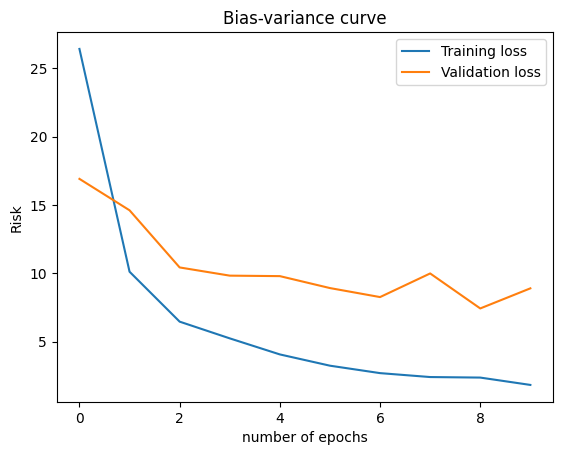

In [29]:
# Now plot the curve
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('number of epochs')
plt.ylabel('Risk')
plt.title('Bias-variance curve')

## Regularize with L2 and early stopping

In [52]:
class Fully_Connected_Net:
    def __init__(self, in_length, neuron, l2_reg):
        self.weights = np.random.randn(in_length, neuron)
        self.biases = np.zeros(neuron)
        self.l2_reg = l2_reg
    
    # Since formula for FC backpropagation is different hence define once again for FC
    def forward_fc(self, input_data):    
        self.last_input_shape = input_data.shape
        # Flatten the data to feed forward
        input_data = input_data.flatten()
        self.last_input = input_data
        # First activation 
        active = np.dot(input_data, self.weights) + self.biases
        self.last_layer_out = active
        # Take softmax and return
        exp = np.exp(active)
        Weight = self.weights
        Bias = self.biases
        return (exp/np.sum(exp, axis=0)), Weight, Bias
    
    # Backpropagation for FC Net
    def backprop_FC(self, loss_grad, learn_rate, l2_reg):       
        # Check whether the gradient is zero
        for i, gradient in enumerate(loss_grad):
            if(gradient == 0):
                continue
            last_exp = np.exp(self.last_layer_out)
            Sum_last = np.sum(np.exp(self.last_layer_out))
            # Now find the derivative
            d_out = -last_exp[i] * last_exp/ (Sum_last**2)
            d_out[i] = last_exp[i] * (Sum_last-last_exp[i]) /(Sum_last**2)
            
            # Gradients weights/biases
            dw1 = self.last_input
            db1 = 1
            dinput = self.weights
            # Gradients of loss with respect to output
            df1 = gradient * d_out   
            # Gradients of loss of next
            dw2 = dw1[np.newaxis].T @ df1[np.newaxis]
            db2 = df1 * db1  
            d_inp = dinput @ df1           
            
            # L2 regularization update
            dw2 += self.l2_reg * self.weights
            db2 += self.l2_reg * self.biases
            
            # Now use gradient descent to update the weights
            self.weights -= learn_rate * dw2
            self.biases -= learn_rate * db2
        
        return d_inp.reshape(self.last_input_shape)


In [53]:
# Make an instance for all these classes
convolution_layer = image_convolution(20)
pooling_layer = MaxPooling()
classification = Fully_Connected_Net(13 * 13 * 20, 10, 0.1)

# Now make a forward function which combine all forward models
def feed_forward(input_image, input_label):
    # First pass to convolution layer
    convolved = convolution_layer.forward_prop((input_image/255))
    # Then paa through pooling layer
    pooled = pooling_layer.forward_max(convolved)
    # Now classification layer
    classi, Weight, Bias = classification.forward_fc(pooled)   
    # Find loss with L2 regularization
    loss = -np.log(classi[input_label])
    # Apply regularization
    l2_reg = 0.5*(np.sum(Weight ** 2))
    if(np.argmax(classi) == input_label):
        accuracy =1 
    else: 
        accuracy= 0
    return classi, loss, accuracy, Weight, Bias, l2_reg

# Make a function which train it
def train(trainX, trainy, learning_rate=0.005):
    # Feed to forward model
    prediction, loss, acc,_,_, l2_reg = feed_forward(trainX, trainy)
    # Initialialize gradient
    gradient = np.zeros(10)
    gradient[trainy] = -1/prediction[trainy]
    # Update weights by Backpropagation
    gradient = classification.backprop_FC(gradient, learning_rate, l2_reg)
    pool = pooling_layer.backprop_max(gradient)
    gradient = convolution_layer.backprop_conv(pool, learning_rate)   
    return loss, acc
  
# Now simply make data ready and call the training function
epochs = 10
m = trainX.shape[0]
n = valx.shape[0]
train_loss = []
valid_loss = []
max_loss = 1000
for epoch in range(epochs):
    print('---Training epoch %d ---'%(epoch+1))
    epoch_loss = 0
    epoch_accu = 0
    for t, (image_batch, label_batch) in enumerate(zip(trainX, trainy)):
        img_loss, img_accu = train(image_batch, label_batch)
        epoch_loss += img_loss
        epoch_accu += img_accu
    train_loss.append(epoch_loss/m)
    validation_loss = 0
    validation_accuracy = 0
    for k, (val_img, val_lab) in enumerate(zip(valx, valy)):
      classi, val_loss, val_acc, Weight, Bias, _ = feed_forward(val_img, val_lab)
      validation_loss += val_loss
      validation_accuracy += val_acc

    # Early stopping 
    t = validation_loss/n
    valid_loss.append(t)
    # Copy the weights
    if max_loss >= t:
      Bias = Bias
      Weight = Weight
      print(f"Epoch {epoch+1} training loss {epoch_loss/m:.4f} train_accuracy {(epoch_accu/m)*100:.4f}, val_loss {t:.4f} val_accuracy {(validation_accuracy/n)*100:.4f} And val-loss deacreasing")
      max_loss = t
    else:
      print('Validation accuracy is not increasing. Stopping in 2 observations')

---Training epoch 1 ---
Epoch 1 training loss 30.9591 train_accuracy 47.4000, val_loss 8.0737 val_accuracy 74.9000 And val-loss deacreasing
---Training epoch 2 ---
Validation accuracy is not increasing. Stopping in 2 observations
---Training epoch 3 ---
Validation accuracy is not increasing. Stopping in 2 observations
---Training epoch 4 ---
Validation accuracy is not increasing. Stopping in 2 observations
---Training epoch 5 ---
Validation accuracy is not increasing. Stopping in 2 observations
---Training epoch 6 ---
Validation accuracy is not increasing. Stopping in 2 observations
---Training epoch 7 ---
Epoch 7 training loss 6.2723 train_accuracy 72.8000, val_loss 7.4540 val_accuracy 76.3000 And val-loss deacreasing
---Training epoch 8 ---
Validation accuracy is not increasing. Stopping in 2 observations
---Training epoch 9 ---
Epoch 9 training loss 6.8390 train_accuracy 73.1000, val_loss 6.5660 val_accuracy 74.0000 And val-loss deacreasing
---Training epoch 10 ---
Validation accura

Text(0.5, 1.0, 'Bias-variance curve')

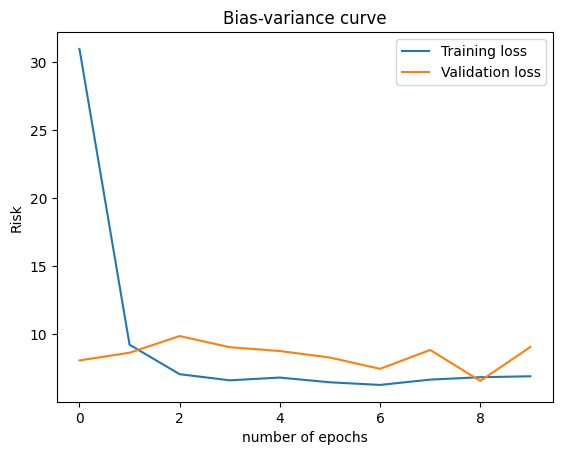

In [54]:
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('number of epochs')
plt.ylabel('Risk')
plt.title('Bias-variance curve')

## Regularize by input perturbation with additive Gaussian noise

In [1]:
# Make convolution class and forward, and backward propagation of it 
class image_convolution:    
    def __init__(self, total_filter):
        self.num_filters = total_filter
        # Initialize the weight matrix
        self.weight_matrix = np.random.randn(total_filter, 3, 3)
    # For convolution we need to split into weight matrix size patches
    def patch_maker(self, image): 
        height, width = image.shape
        # Itrate all regions and split into 3x3   
        for i in range(height-2):
            for j in range(width-2):
                img_patch = image[i:(i+3), j:(j+3)]
                yield img_patch, i, j
    # Now feed forward propagation        
    def forward_prop(self, input):
        self.last_input = input    
        height, width = input.shape
        # Make a dummy matrix to store the output    
        dummy_out = np.zeros((height-2, width-2, self.num_filters))
        # Now find patches using patch maker    
        for img_patch, i, j in self.patch_maker(input):
            dummy_out[i, j] = np.sum(img_patch * self.weight_matrix, axis=(1,2))
        return dummy_out
    # Simultaneously define backpropapgation for convolution
    def backprop_conv(self, loss_grad_out, learning_rate):
        # Initalize a matrix to store gradient loss of weights
        weight_grad_loss = np.zeros(self.weight_matrix.shape)
        for img_patch, i, j in self.patch_maker(self.last_input):
            for f in range(self.num_filters):
                weight_grad_loss[f] += loss_grad_out[i,j,f] * img_patch
        # use gradient descent to update weights
        self.weight_matrix -= learning_rate * weight_grad_loss
        return None

In [2]:
# Now make a class for maxpooling
class MaxPooling:
    def img_pooler(self, image):
        height, width, _ = image.shape
        # Since we need to have (2, 2) pooling    
        new_h = height // 2
        new_w = width // 2
        # Now divide it on 2x2 patches
        for i in range(new_h):
            for j in range(new_w):
                img_patch = image[(i*2):(i*2+2), (j*2):(j*2+2)]
                yield img_patch, i, j
    # Again for maxpooling make a feed_forward function            
    def forward_max(self, input):
        self.final_input = input
        # Find dimesnsion of input    
        height, width, matrix_count = input.shape
        output = np.zeros((height//2, width//2, matrix_count))
        # For each pooled patch find output
        for img_patch, i, j in self.img_pooler(input):
            output[i,j] = np.amax(img_patch,axis=(0,1))    
        return output
     # Same way define the backpropagation for MaxPooling
    def backprop_max(self, loss_grad_out):
        loss_grad_input = np.zeros(self.final_input.shape)
        # Now from enter into each img_patch
        for img_patch, i, j in self.img_pooler(self.final_input):
            height, width, weight_matrix = img_patch.shape
            patch_maxima = np.amax(img_patch, axis=(0,1))
            # Now iterate in all weight matrix all elements
            for row in range(height):
                for col in range(width):
                    for channel in range(weight_matrix):
                        #if the pixel was the max value, copy the gradient to it
                        if(img_patch[row,col,channel] == patch_maxima[channel]):
                            loss_grad_input[i*2+row, j*2+col ,channel] = loss_grad_out[i, j, channel]
                            break
        return loss_grad_input


In [3]:

 # Define the last class for classification network
class Fully_Connected_Net:
    def __init__(self, in_length, neuron):
        self.weights = np.random.randn(in_length, neuron)
        self.biases = np.zeros(neuron)
    
    # Since formula for FC backpropagation is different hence define once again for FC
    def forward_fc(self, input_data):    
        self.last_input_shape = input_data.shape
        # Flatten the data to feed forward
        input_data = input_data.flatten()
        self.last_input = input_data
        # First activation 
        active = np.dot(input_data, self.weights) + self.biases
        self.last_layer_out = active
        # Take softmax and return
        exp = np.exp(active)
        return(exp/np.sum(exp, axis=0)) 
    
    # Backpropagation for FC Net
    def backprop_FC(self, loss_grad, learn_rate):       
        # Check whether the gradient is zero
        for i, gradient in enumerate(loss_grad):
            if(gradient == 0):
                continue
            last_exp = np.exp(self.last_layer_out)
            Sum_last = np.sum(np.exp(self.last_layer_out))
            # Now find the derivative
            d_out = -last_exp[i] * last_exp/ (Sum_last**2)
            d_out[i] = last_exp[i] * (Sum_last-last_exp[i]) /(Sum_last**2)
            
            # Gradients weights/biases
            dw1 = self.last_input
            db1 = 1
            dinput = self.weights
            # Gradients of loss with respect to output
            df1 = gradient * d_out   
            # Gradients of loss of next
            dw2 = dw1[np.newaxis].T @ df1[np.newaxis]
            db2 = df1 * db1  
            d_inp = dinput @ df1           
            # Now use gradient descent to update the weights
            self.weights -= learn_rate * dw2
            self.biases -= learn_rate * db2
            return d_inp.reshape(self.last_input_shape)

In [21]:
# Add gaussian noise
p, q, r = trainX.shape
noise1 = np.random.randn(p, q, r)
trainX = trainX + noise1
p1,q1,r1 = valx.shape
noise2 = np.random.randn(p1, q1, r1)
valx = valx + noise2

In [23]:
# Make an instance for all these classes
convolution_layer = image_convolution(20)
pooling_layer = MaxPooling()
classification = Fully_Connected_Net(13 * 13 * 20, 10)

# Now make a forward function which combine all forward models
def feed_forward(input_image, input_label):
    # First pass to convolution layer
    convolved = convolution_layer.forward_prop((input_image/255))
    # Then paa through pooling layer
    pooled = pooling_layer.forward_max(convolved)
    # Now classification layer
    classi = classification.forward_fc(pooled)   
    # Find accuracy metric
    loss = -np.log(classi[input_label])
    if(np.argmax(classi) == input_label):
        accuracy =1 
    else: 
        accuracy= 0
    return classi, loss, accuracy

# Make a function which train it
def train(trainX, trainy, learning_rate=0.005):
    # Feed to forward model
    prediction, loss, acc = feed_forward(trainX, trainy)
    # Initialialize gradient
    gradient = np.zeros(10)
    gradient[trainy] = -1/prediction[trainy]
    # Update weights by Backpropagation
    gradient = classification.backprop_FC(gradient, learning_rate)
    pool = pooling_layer.backprop_max(gradient)
    gradient = convolution_layer.backprop_conv(pool, learning_rate)   
    return loss, acc
  
# Now simply make data ready and call the training function
epochs = 10
m = trainX.shape[0]
n = valx.shape[0]
train_loss = []
valid_loss = []
for epoch in range(epochs):
    print('---Training epoch %d ---'%(epoch+1))
    epoch_loss = 0
    epoch_accu = 0
    for t, (image_batch, label_batch) in enumerate(zip(trainX, trainy)):
        img_loss, img_accu = train(image_batch, label_batch)
        epoch_loss += img_loss
        epoch_accu += img_accu
    train_loss.append(epoch_loss/m)
    validation_loss = 0
    validation_accuracy = 0
    for k, (val_img, val_lab) in enumerate(zip(valx, valy)):
      classi, val_loss, val_acc = feed_forward(val_img, val_lab)
      validation_loss += val_loss
      validation_accuracy += val_acc
    valid_loss.append(validation_loss/n)
    print(f"Epoch {epoch+1} training loss {epoch_loss/m:.4f} train_accuracy {(epoch_accu/m)*100:.4f}, val_loss {validation_loss/n:.4f} val_accuracy {(validation_accuracy/n)*100:.4f}")


---Training epoch 1 ---
Epoch 1 training loss 27.1009 train_accuracy 42.6000, val_loss 20.3585 val_accuracy 48.0000
---Training epoch 2 ---
Epoch 2 training loss 9.7505 train_accuracy 68.8000, val_loss 17.8602 val_accuracy 56.0000
---Training epoch 3 ---
Epoch 3 training loss 6.3320 train_accuracy 74.6000, val_loss 14.6066 val_accuracy 59.5000
---Training epoch 4 ---
Epoch 4 training loss 5.7322 train_accuracy 77.3000, val_loss 13.3687 val_accuracy 59.5000
---Training epoch 5 ---
Epoch 5 training loss 5.1623 train_accuracy 79.7000, val_loss 18.6194 val_accuracy 51.0000
---Training epoch 6 ---
Epoch 6 training loss 5.3974 train_accuracy 79.6000, val_loss 11.9424 val_accuracy 72.5000
---Training epoch 7 ---
Epoch 7 training loss 3.8026 train_accuracy 83.6000, val_loss 11.8898 val_accuracy 71.5000
---Training epoch 8 ---
Epoch 8 training loss 3.6814 train_accuracy 86.0000, val_loss 14.0472 val_accuracy 68.5000
---Training epoch 9 ---
Epoch 9 training loss 4.3587 train_accuracy 84.0000, va

Text(0.5, 1.0, 'Bias-variance curve')

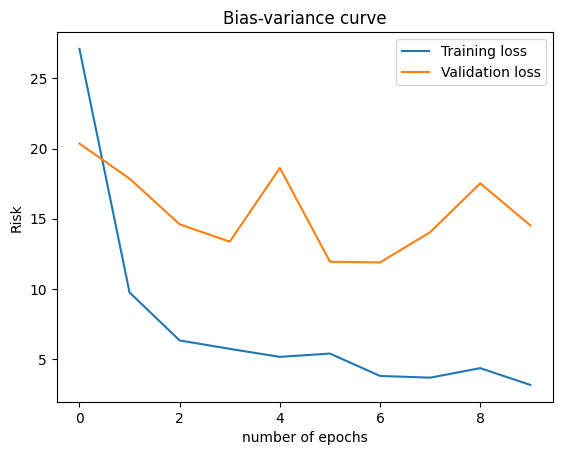

In [24]:
# Plot the bias varaince curve
plt.plot(train_loss)
plt.plot(valid_loss)
plt.legend(['Training loss', 'Validation loss'])
plt.xlabel('number of epochs')
plt.ylabel('Risk')
plt.title('Bias-variance curve')

# P7 (Neural Networks, MLP)

Train an MLP on the PCA counterpart of the KMINST dataset and report your observations

**DATA:** `p5[data]`

In [286]:
mlp = [[] for _ in range(4)]
n_labels = len(np.unique(p4['Y']))

# Shuffle the training data randomly
indices = np.arange(p5['X'].shape[0])
np.random.shuffle(indices)

s = int(0.7 * p5['X'].shape[0])
xtrain, xval = p5['X'][indices[:s]], p5['X'][indices[s:]]
ytrain, yval = p5['Y'][indices[:s]], p5['Y'][indices[s:]]

layers = [xtrain.shape[1], 32, n_labels]
mlp[0] = MLP(layers, 'sigmoid', 'softmax','ce', learning_rate = 0.1)

train_losses, val_losses, train_accs, val_accs = mlp[0].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

/tmp/ipykernel_1435218/786607946.py:14: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


Epoch 1: 	  train_loss = 1901.53  	val_loss = 821.29 	  train_acc = 0.82  	 val_acc = 0.82
Epoch 2: 	  train_loss = 1331.07  	val_loss = 577.65 	  train_acc = 0.85  	 val_acc = 0.85
Epoch 3: 	  train_loss = 1130.10  	val_loss = 491.74 	  train_acc = 0.86  	 val_acc = 0.86
Epoch 4: 	  train_loss = 1041.30  	val_loss = 459.21 	  train_acc = 0.87  	 val_acc = 0.86
Epoch 5: 	  train_loss = 965.91  	val_loss = 426.14 	  train_acc = 0.88  	 val_acc = 0.87
Epoch 6: 	  train_loss = 935.50  	val_loss = 413.98 	  train_acc = 0.87  	 val_acc = 0.87
Epoch 7: 	  train_loss = 884.92  	val_loss = 394.73 	  train_acc = 0.88  	 val_acc = 0.88
Epoch 8: 	  train_loss = 859.36  	val_loss = 383.16 	  train_acc = 0.88  	 val_acc = 0.88
Epoch 9: 	  train_loss = 835.14  	val_loss = 374.90 	  train_acc = 0.89  	 val_acc = 0.88
Epoch 10: 	  train_loss = 810.50  	val_loss = 365.90 	  train_acc = 0.89  	 val_acc = 0.88
Epoch 11: 	  train_loss = 790.91  	val_loss = 356.96 	  train_acc = 0.89  	 val_acc = 0.89
Epoc

In [287]:
layers = [xtrain.shape[1], 64, 32, n_labels]
mlp[1] = MLP(layers, 'relu', 'softmax','mse', learning_rate = 0.01)

train_losses, val_losses, train_accs, val_accs = mlp[1].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

/tmp/ipykernel_1435218/786607946.py:28: RuntimeWarning: invalid value encountered in divide
  return exp_z / np.sum(exp_z, axis=0, keepdims=True)


Epoch 1: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 2: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 3: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 4: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 5: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 6: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 7: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 8: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 9: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 10: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 11: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 12: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_

In [288]:
layers = [xtrain.shape[1], 128, 64, 32, n_labels]
mlp[2] = MLP(layers, 'sigmoid', 'softmax','mse', learning_rate = 0.1)

train_losses, val_losses, train_accs, val_accs = mlp[2].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

/tmp/ipykernel_1435218/786607946.py:14: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


Epoch 1: 	  train_loss = 940.97  	val_loss = 403.33 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 2: 	  train_loss = 928.85  	val_loss = 398.03 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 3: 	  train_loss = 901.26  	val_loss = 386.18 	  train_acc = 0.53  	 val_acc = 0.54
Epoch 4: 	  train_loss = 855.13  	val_loss = 366.33 	  train_acc = 0.58  	 val_acc = 0.59
Epoch 5: 	  train_loss = 768.32  	val_loss = 329.10 	  train_acc = 0.70  	 val_acc = 0.70
Epoch 6: 	  train_loss = 656.37  	val_loss = 281.27 	  train_acc = 0.78  	 val_acc = 0.78
Epoch 7: 	  train_loss = 538.16  	val_loss = 230.81 	  train_acc = 0.80  	 val_acc = 0.80
Epoch 8: 	  train_loss = 435.75  	val_loss = 187.01 	  train_acc = 0.84  	 val_acc = 0.83
Epoch 9: 	  train_loss = 368.09  	val_loss = 158.20 	  train_acc = 0.84  	 val_acc = 0.84
Epoch 10: 	  train_loss = 317.87  	val_loss = 137.24 	  train_acc = 0.85  	 val_acc = 0.85
Epoch 11: 	  train_loss = 281.98  	val_loss = 122.28 	  train_acc = 0.86  	 val_acc = 0.86
Epoch 12

In [289]:
layers = [xtrain.shape[1], 256, 128, 64, 32, n_labels]
mlp[3] = MLP(layers, 'relu', 'softmax','ce', learning_rate = 0.1)

train_losses, val_losses, train_accs, val_accs = mlp[3].train(xtrain, ytrain, xval, yval, num_epochs = 50 , batch_size = 256)

/tmp/ipykernel_1435218/786607946.py:28: RuntimeWarning: invalid value encountered in divide
  return exp_z / np.sum(exp_z, axis=0, keepdims=True)


Epoch 1: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 2: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 3: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 4: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 5: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 6: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 7: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 8: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 9: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 10: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 11: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_acc = 0.10
Epoch 12: 	  train_loss = nan  	val_loss = nan 	  train_acc = 0.10  	 val_

#### Final accuracy and F1 score

In [291]:
models = ["1 hidden layer, activation function: 'sigmoid', loss function: 'cross-entropy'",
         "2 hidden layers, activation function: 'relu', loss function: 'mean squared error'",
         "3 hidden layers, activation function: 'sigmoid', loss function: 'mean squared error'",
         "4 hidden layers, activation function: 'relu', loss function: 'cross-entropy'"]

for i in range(4):
    pred = np.argmax(mlp[i].forward(p5['X_test']), axis=1)
    cnf = metrics.confusionMatrix(pred, p5['Y_test'], n_labels)
    acc = metrics.accuracy(pred, p5['Y_test'])
    f1 = metrics.f1Score(cnf)
                         
    print(models[i])
    print("Classification Accuracy : ", acc * 100, "%")
    print("               F1 Score : ", np.mean(f1))
    print("-------------------------------------------------------------------------------------")

/tmp/ipykernel_1435218/786607946.py:14: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp(-z))


1 hidden layer, activation function: 'sigmoid', loss function: 'cross-entropy'
Classification Accuracy :  92.05666666666666 %
               F1 Score :  0.9205688141449585
-------------------------------------------------------------------------------------
2 hidden layers, activation function: 'relu', loss function: 'mean squared error'
Classification Accuracy :  10.0 %
               F1 Score :  0.018181818016517907
-------------------------------------------------------------------------------------
3 hidden layers, activation function: 'sigmoid', loss function: 'mean squared error'
Classification Accuracy :  92.99 %
               F1 Score :  0.929918543157336
-------------------------------------------------------------------------------------
4 hidden layers, activation function: 'relu', loss function: 'cross-entropy'
Classification Accuracy :  10.0 %
               F1 Score :  0.018181818016517907
----------------------------------------------------------------------------------